In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Humor Bengali Dataset - Sheet1.csv'
data = pd.read_csv(file_path)

In [ ]:
texts = data['Text'].tolist()
labels = data['Humor'].tolist()

label_dict = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = [label_dict[label] for label in labels]

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, numeric_labels, test_size=0.1, random_state=42)


tokenizer = AutoTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

bangla_bert_model = AutoModelForSequenceClassification.from_pretrained('sagorsarker/bangla-bert-base', num_labels=len(label_dict))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bangla_bert_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Epoch 1 - Train Accuracy: 0.596386476426799 - Train Loss: 0.664526146191817
Epoch 1 - Test Accuracy: 0.687099358974359 - Test Loss: 0.6131464242935181
Epoch 2 - Train Accuracy: 0.6628411910669976 - Train Loss: 0.6005772077120267
Epoch 2 - Test Accuracy: 0.733974358974359 - Test Loss: 0.5644731521606445
Epoch 3 - Train Accuracy: 0.6987437965260546 - Train Loss: 0.5590735880228189
Epoch 3 - Test Accuracy: 0.7467948717948718 - Test Loss: 0.5312077403068542
Epoch 4 - Train Accuracy: 0.7336771091811414 - Train Loss: 0.5167885170533106
Epoch 4 - Test Accuracy: 0.7467948717948718 - Test Loss: 0.510669618844986
Epoch 5 - Train Accuracy: 0.7529466501240696 - Train Loss: 0.49084837390826297
Epoch 5 - Test Accuracy: 0.7389823717948718 - Test Loss: 0.4915495812892914
Epoch 6 - Train Accuracy: 0.7927651985111663 - Train Loss: 0.44976407977250904
Epoch 6 - Test Accuracy: 0.7389823717948718 - Test Loss: 0.47762979567050934
Epoch 7 - Train Accuracy: 0.8121122828784119 - Train Loss: 0.4144028127193451


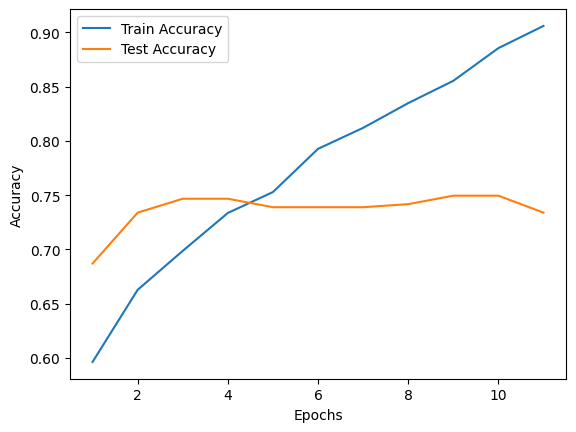

In [ ]:
epochs = 11
batch_size = 64
optimizer = torch.optim.AdamW(bangla_bert_model.parameters(), lr=5e-6)
criterion = torch.nn.CrossEntropyLoss()

train_accuracy_values = []
train_loss_values = []

test_accuracy_values = []
test_loss_values = []

for epoch in range(epochs):
    bangla_bert_model.train()
    total_train_accuracy = 0
    total_train_loss = 0
    total_batches = 0

    for i in range(0, len(train_encodings['input_ids']), batch_size):
        optimizer.zero_grad()
        batch_input = {key: val[i:i+batch_size].to(device) for key, val in train_encodings.items()}
        labels = train_labels[i:i+batch_size].to(device)
        outputs = bangla_bert_model(**batch_input)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        batch_accuracy = torch.sum(predictions == labels).item() / len(predictions)
        total_train_accuracy += batch_accuracy
        total_batches += 1

    epoch_train_accuracy = total_train_accuracy / total_batches
    epoch_train_loss = total_train_loss / total_batches
    train_accuracy_values.append(epoch_train_accuracy)
    train_loss_values.append(epoch_train_loss)
    print(f"Epoch {epoch+1} - Train Accuracy: {epoch_train_accuracy} - Train Loss: {epoch_train_loss}")

    # Test Evaluation
    bangla_bert_model.eval()
    total_test_accuracy = 0
    total_test_loss = 0
    total_test_batches = 0

    with torch.no_grad():
        for i in range(0, len(test_encodings['input_ids']), batch_size):
            batch_input = {key: val[i:i+batch_size].to(device) for key, val in test_encodings.items()}
            labels = test_labels[i:i+batch_size].to(device)
            outputs = bangla_bert_model(**batch_input)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_test_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            batch_accuracy = torch.sum(predictions == labels).item() / len(predictions)
            total_test_accuracy += batch_accuracy
            total_test_batches += 1

    epoch_test_accuracy = total_test_accuracy / total_test_batches
    epoch_test_loss = total_test_loss / total_test_batches
    test_accuracy_values.append(epoch_test_accuracy)
    test_loss_values.append(epoch_test_loss)
    print(f"Epoch {epoch+1} - Test Accuracy: {epoch_test_accuracy} - Test Loss: {epoch_test_loss}")

bangla_bert_model.eval()
total_test_accuracy = 0
total_test_batches = 0
all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for i in range(0, len(test_encodings['input_ids']), batch_size):
        batch_input = {key: val[i:i+batch_size].to(device) for key, val in test_encodings.items()}
        labels = test_labels[i:i+batch_size].to(device)
        outputs = bangla_bert_model(**batch_input)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        batch_accuracy = torch.sum(predictions == labels).item() / len(predictions)
        total_test_accuracy += batch_accuracy
        total_test_batches += 1

precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')

print(f"Test Precision: {precision} - Test Recall: {recall} - Test F1 Score: {f1}")

plt.plot(range(1, epochs+1), train_accuracy_values, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()







Epoch 1 - Train Accuracy: 0.9205179900744417 - Train Loss: 0.22483898011537698
Epoch 1 - Test Accuracy: 0.7546073717948718 - Test Loss: 0.5043129473924637
Epoch 2 - Train Accuracy: 0.9409119106699753 - Train Loss: 0.1879334312218886
Epoch 2 - Test Accuracy: 0.733974358974359 - Test Loss: 0.5293251872062683
Epoch 3 - Train Accuracy: 0.9494416873449132 - Train Loss: 0.16285431270415968
Epoch 3 - Test Accuracy: 0.7546073717948718 - Test Loss: 0.5492226183414459
Epoch 4 - Train Accuracy: 0.9650666873449132 - Train Loss: 0.132231300840011
Epoch 4 - Test Accuracy: 0.7467948717948718 - Test Loss: 0.5744669735431671
Epoch 5 - Train Accuracy: 0.977085918114144 - Train Loss: 0.09724924713373184
Epoch 5 - Test Accuracy: 0.7467948717948718 - Test Loss: 0.6176063418388367
Test Precision: 0.7577287161880508 - Test Recall: 0.7475728155339806 - Test F1 Score: 0.745414908371942


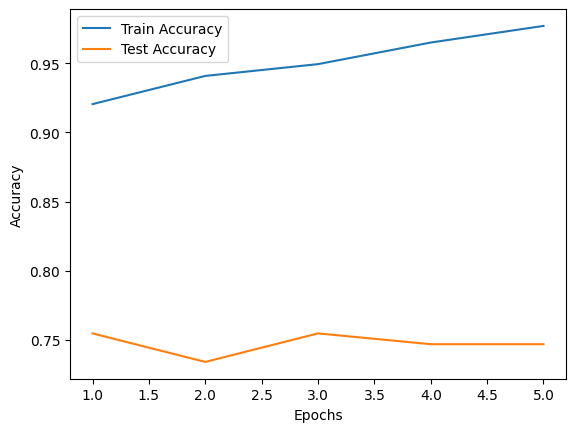

In [ ]:
epochs = 5
batch_size = 64
optimizer = torch.optim.AdamW(bangla_bert_model.parameters(), lr=5e-6)
criterion = torch.nn.CrossEntropyLoss()

train_accuracy_values = []
train_loss_values = []

test_accuracy_values = []
test_loss_values = []

for epoch in range(epochs):
    bangla_bert_model.train()
    total_train_accuracy = 0
    total_train_loss = 0
    total_batches = 0

    for i in range(0, len(train_encodings['input_ids']), batch_size):
        optimizer.zero_grad()
        batch_input = {key: val[i:i+batch_size].to(device) for key, val in train_encodings.items()}
        labels = train_labels[i:i+batch_size].to(device)
        outputs = bangla_bert_model(**batch_input)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        batch_accuracy = torch.sum(predictions == labels).item() / len(predictions)
        total_train_accuracy += batch_accuracy
        total_batches += 1

    epoch_train_accuracy = total_train_accuracy / total_batches
    epoch_train_loss = total_train_loss / total_batches
    train_accuracy_values.append(epoch_train_accuracy)
    train_loss_values.append(epoch_train_loss)
    print(f"Epoch {epoch+1} - Train Accuracy: {epoch_train_accuracy} - Train Loss: {epoch_train_loss}")

    # Test Evaluation
    bangla_bert_model.eval()
    total_test_accuracy = 0
    total_test_loss = 0
    total_test_batches = 0

    with torch.no_grad():
        for i in range(0, len(test_encodings['input_ids']), batch_size):
            batch_input = {key: val[i:i+batch_size].to(device) for key, val in test_encodings.items()}
            labels = test_labels[i:i+batch_size].to(device)
            outputs = bangla_bert_model(**batch_input)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_test_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            batch_accuracy = torch.sum(predictions == labels).item() / len(predictions)
            total_test_accuracy += batch_accuracy
            total_test_batches += 1

    epoch_test_accuracy = total_test_accuracy / total_test_batches
    epoch_test_loss = total_test_loss / total_test_batches
    test_accuracy_values.append(epoch_test_accuracy)
    test_loss_values.append(epoch_test_loss)
    print(f"Epoch {epoch+1} - Test Accuracy: {epoch_test_accuracy} - Test Loss: {epoch_test_loss}")

bangla_bert_model.eval()
total_test_accuracy = 0
total_test_batches = 0
all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for i in range(0, len(test_encodings['input_ids']), batch_size):
        batch_input = {key: val[i:i+batch_size].to(device) for key, val in test_encodings.items()}
        labels = test_labels[i:i+batch_size].to(device)
        outputs = bangla_bert_model(**batch_input)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        batch_accuracy = torch.sum(predictions == labels).item() / len(predictions)
        total_test_accuracy += batch_accuracy
        total_test_batches += 1

precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')

print(f"Test Precision: {precision} - Test Recall: {recall} - Test F1 Score: {f1}")

plt.plot(range(1, epochs+1), train_accuracy_values, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





